# 5장.그리기
- CycleGAN, Style Transfer를 학습한다

## 5.1 CycleGAN
- CycleGAN 실습을 위한 데이터는 아래 링크에서 다운로드 받으세요.
    - https://www.kaggle.com/datasets/balraj98/apple2orange-dataset?resource=download [1]
    - 데이터를 ./data/apple2orange folder에 넣습니다. 이 폴더 안에는 [trainA, testA, trainB, testB, metadata.csv] 가 들어있어야합니다.
    - A는 Apple을 B는 Orange를 담고있습니다.

    
[1] Zhu et al., Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks, ICCV 2017


<p align="center">
    <img src="https://pyimagesearch.com/wp-content/uploads/2022/09/Cycle-GAN-Featured-1.png")
<!-- ![](https://dukakis.org/wp-content/uploads/sites/15/1-5-1-500x356.jpg) -->
</p>
출처 : https://pyimagesearch.com/2022/09/12/cyclegan-unpaired-image-to-image-translation-part-1/



- CycleGAN은 네 개의 모델로 구성된다
    - [g_AB, g_BA, d_A, d_B]
        - g_AB : A에서 B로 변환하는 generator
        - g_BA : B에서 A로 변환하는 generator
        - d_A : A인지 판별하는 discriminator
        - d_B : B인지 판별하는 discriminator

- CycleGAN은 지금까지 우리가 고안한 GAN과는 조금 다른 특징을 가진다
    - 지금까지 고안한 GAN은 생성에 방향성이 있었다. 예를 들어 노이즈 $z$가 사람의 얼굴이 된다거나 사람 얼굴 스케치가 실제 사람 얼굴이 된다거나(pix2pix)
    - 하지만 CycleGAN은 Source와 Target domain의 구분이 없다

### 5.1.1 데이터 살펴보기
- 랜덤한 crawling으로 데이터를 얻었다고 사료된다
- 예를들어 "사과" 폴더에는 사과가 아닌 instance가 꽤나 등장한다(e.g. 사람)

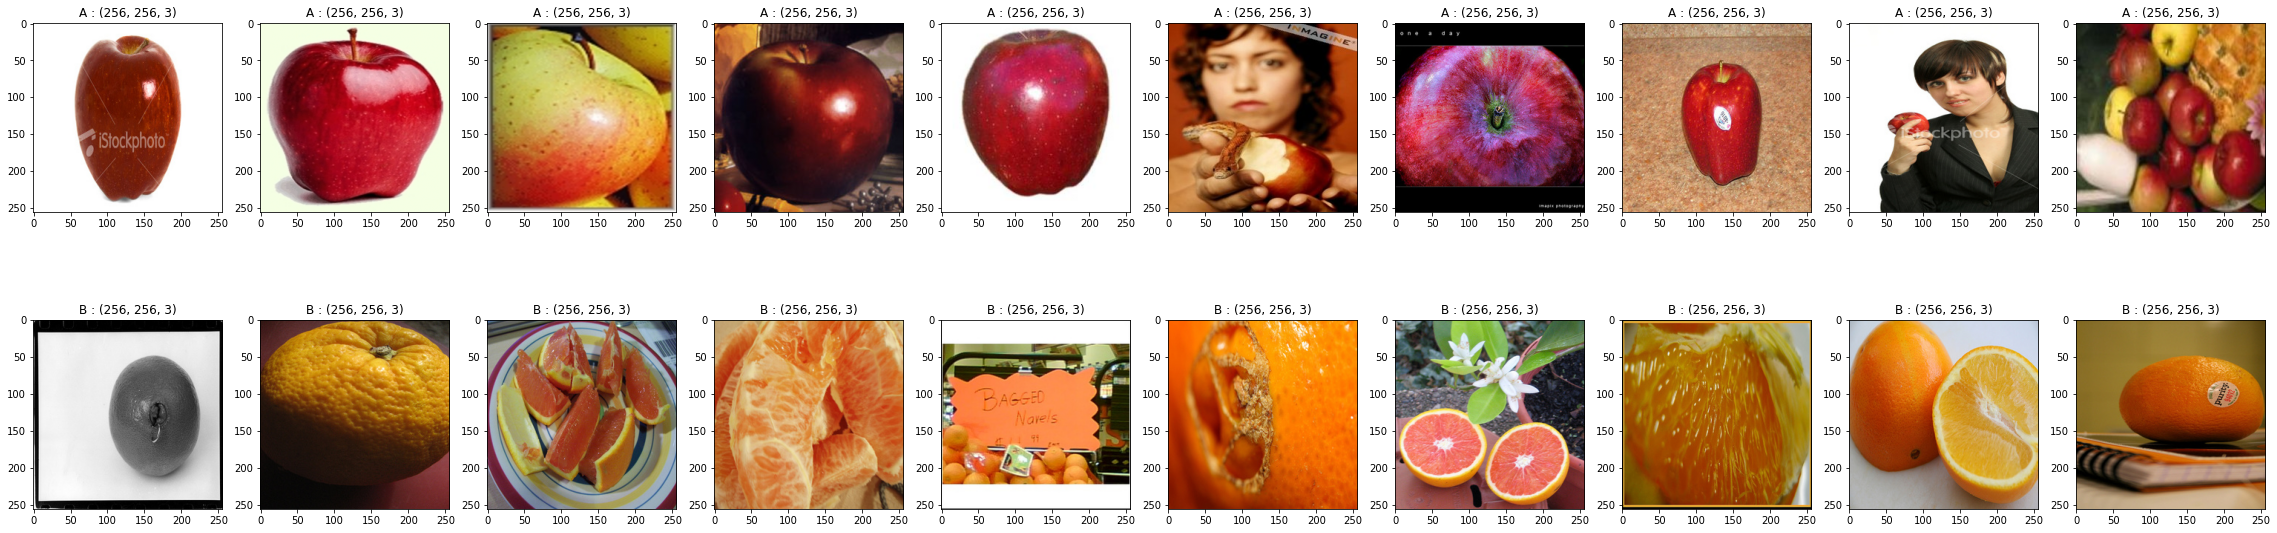

In [59]:
import os
import matplotlib.pyplot as plt

apples = os.listdir('./data/apple2orange/trainA/')[0:10]
oranges = os.listdir('./data/apple2orange/trainB/')[0:10]

plt.figure(figsize=(40,10))
for col, fruit in enumerate(['A','B']):
    for row in range(10):
        img_name = {"A":apples, "B":oranges}[fruit][row]
        img = plt.imread(f'./data/apple2orange/train{fruit}/{img_name}')/255
        plt.subplot(2,10,col*10+row+1)
        plt.imshow(img)
        plt.title(f'{fruit} : {img.shape}')

### 5.1.2 생성자(U-Net)

<p align="center">
    <img src="https://miro.medium.com/v2/resize:fit:720/format:webp/1*TXfEPqTbFBPCbXYh2bstlA.png")
<!-- ![](https://dukakis.org/wp-content/uploads/sites/15/1-5-1-500x356.jpg) -->
</p>

Image from : Ronneberger et al., U-Net: Convolutional Networks for Biomedical Image Segmentation, MICCAI 2015


- Unet은 Image -> Mask를 출력하는 Segmentation Network이지만, Output의 shape을 조금만 바꾸면 원본 3차원 이미지 shape을 유지하게 할 수도 있고 다양한 shape으로 원하는 task를 맡길 수 있다
    - 이 CycleGAN에서도 그렇고 pix2pix에서도 그렇고 Unet은 Generator로 자주 사용된다

In [97]:
import torch
import torch.nn as nn
from torchsummary import summary



class UNet(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, drop_out=None):
        super().__init__()
        downsamplers_list = []
        upsamplers_list = []
        for i,_ in enumerate(in_channels):
            downsamplers_list.append(DownSample(in_channels[i],
                                                out_channels[i],
                                                kernel_size[i],
                                                stride[i],
                                                padding[i]))
            r_i = -i-1 # reversed i
            apex = True if r_i == -1 else False
            activation = nn.Sigmoid if i == (len(in_channels)-1) else nn.ReLU
            upsamplers_list.append(UpSample(out_channels[r_i],
                                            in_channels[r_i],
                                            kernel_size[r_i],
                                            stride[r_i],
                                            padding[r_i],
                                            drop_out,
                                            apex,
                                            activation))
        else:
            self.downsamplers = nn.ModuleList(downsamplers_list)
            self.upsamplers = nn.ModuleList(upsamplers_list)
    def forward(self,x):
        downsampler_outputs = []
        for i in range(len(self.downsamplers)):
            x = self.downsamplers[i](x)
            downsampler_outputs.append(x)
        for j in range(len(self.upsamplers)):
            try:
                x = self.upsamplers[j](x, downsampler_outputs[-j-2])
            except:
                x = self.upsamplers[j](x)
        return x
    


class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, drop_out=None, apex=False, activation=None):
        super().__init__()
        self.in_channels = in_channels if apex else in_channels*2
        self.apex = apex
        self.layer = nn.Sequential(nn.UpsamplingBilinear2d(scale_factor=4),
                                   nn.Conv2d(self.in_channels, out_channels, kernel_size, stride, padding),
                                   nn.InstanceNorm2d(out_channels))
        if activation is not None:
            self.layer.add_module('activation', activation())
        if drop_out is not None:
            assert drop_out>=0.0 and drop_out<=1.0
            self.layer.add_module('drop_out', nn.Dropout(drop_out))

    def forward(self,x,down_x=None):
        x = self.layer(x)
        if down_x is None:
            return x
        else:
            return torch.cat([x,down_x], dim=1)



class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super().__init__()
        self.layer = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
                                   nn.InstanceNorm2d(out_channels),
                                   nn.ReLU())

    def forward(self,x):
        return self.layer(x)
    


if __name__ == '__main__':
    x = torch.randn((16,3,256,256)).cuda()
    unet = UNet(in_channels=[3,32,64,128],
                out_channels=[32,64,128,256],
                kernel_size=[4,4,4,4],
                stride=[2,2,2,2],
                padding=[1,1,1,1]).cuda()
    recon_x = unet(x)
    print(f'input image shape : {x.shape} | reconstructed image shape : {recon_x.shape}')
    print(f'reonstructed image range : ({torch.min(recon_x):.2f}, {torch.max(recon_x):.2f})\n')
    summary(unet, (3,256,256))

input image shape : torch.Size([16, 3, 256, 256]) | reconstructed image shape : torch.Size([16, 3, 256, 256])
reonstructed image range : (0.00, 1.00)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]           1,568
    InstanceNorm2d-2         [-1, 32, 128, 128]               0
              ReLU-3         [-1, 32, 128, 128]               0
        DownSample-4         [-1, 32, 128, 128]               0
            Conv2d-5           [-1, 64, 64, 64]          32,832
    InstanceNorm2d-6           [-1, 64, 64, 64]               0
              ReLU-7           [-1, 64, 64, 64]               0
        DownSample-8           [-1, 64, 64, 64]               0
            Conv2d-9          [-1, 128, 32, 32]         131,200
   InstanceNorm2d-10          [-1, 128, 32, 32]               0
             ReLU-11          [-1, 128, 32, 32]               0
       DownSampl

In [70]:
3.1 in range(0,44)

False